In [1]:
import random
import torch

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

from collections import defaultdict

from causal_gym import AntMazePCH
from causal_rl.algo.imitation.imitate import *

<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.
/home/et2842/miniconda3/envs/causalenv/lib/python3.11/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
num_steps = 1000
seed = 0
hidden_dims = {'P'}

random.seed(seed)
torch.manual_seed(seed)

In [4]:
env = AntMazePCH(num_steps=num_steps, hidden_dims=hidden_dims, seed=seed)
train_eps = env.expert.num_eps
train_eps

1101

In [ ]:
G = parse_graph(env.get_graph)
X = {f'X{t}' for t in range(num_steps)}
Y = f'Y{num_steps}'
obs_prefix = env.env.observed_unobserved_vars[0]

In [ ]:
Z_sets = find_sequential_pi_backdoor(G, X, Y, obs_prefix)

In [7]:
naive_Z_sets = {}
for Xi in X:
    i = int(Xi[1:])
    cond = set()

    for j in range(i+1):
        cond.update({f'{o}{j}' for o in list(set(obs_prefix) - {'X'})})

    for j in range(i):
        cond.add(f'X{j}')
    naive_Z_sets[Xi] = cond

In [8]:
records = collect_expert_trajectories(
    env,
    num_episodes=train_eps,
    max_steps=num_steps,
    behavioral_policy=None,
    seed=seed
)

In [9]:
hidden_size = 256
lr = 3e-4
batch_size = 512
patience = 20
lookback = 5

dims = {
    'P': 3,
    'O': 4,
    'A': 8,
    'L': 3,
    'T': 3,
    'J': 8,
    'X': 8
}

In [ ]:
causal_model, causal_slots, causal_Z_trim = train_single_policy_long_horizon(
    records,
    Z_sets,
    dims=dims,
    include_vars=obs_prefix,
    lookback=lookback,
    continuous=True,
    num_actions = env.action_space.shape[0],
    hidden_dim=hidden_size,
    lr=lr,
    batch_size=batch_size,
    patience=patience,
    device=device,
    seed=seed
)

causal_policy = shared_policy_fn_long_horizon(causal_model, causal_slots, causal_Z_trim, continuous=True, device=device)
causal_policies = make_shared_policy_dict(causal_policy)

In [11]:
naive_model, naive_slots, naive_Z_trim = train_single_policy_long_horizon(
    records,
    naive_Z_sets,
    dims=dims,
    include_vars=obs_prefix,
    lookback=lookback,
    continuous=True,
    num_actions = env.action_space.shape[0],
    hidden_dim=hidden_size,
    lr=lr,
    batch_size=batch_size,
    patience=patience,
    device=device,
    seed=seed
)

naive_policy = shared_policy_fn_long_horizon(naive_model, naive_slots, naive_Z_trim, continuous=True, device=device)
naive_policies = make_shared_policy_dict(naive_policy)

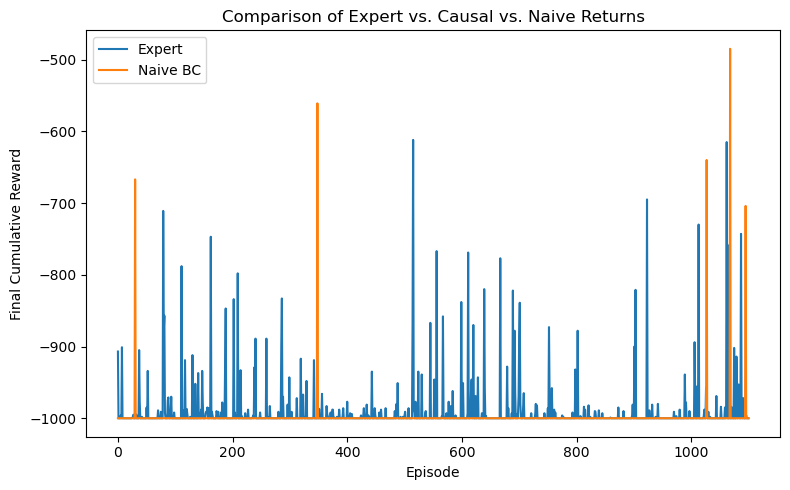

In [ ]:
episode_rewards = defaultdict(float)
for rec in records:
    ep = rec['episode']
    episode_rewards[ep] += float(rec['reward'])

num_eps = len(episode_rewards)

expert_rewards = [episode_rewards[e] for e in range(num_eps)]

causal_returns = eval_policy(env, causal_policies, num_episodes=num_eps, seed=seed)
naive_returns = eval_policy(env, naive_policies, num_episodes=num_eps, seed=seed)

causal_rewards = [ep['return'] for ep in causal_returns]
naive_rewards = [ep['return'] for ep in naive_returns]

plt.figure(figsize=(8,5))
plt.plot(expert_rewards, label='Expert')
plt.plot(causal_rewards, label='Causal BC')
plt.plot(naive_rewards, label='Naive BC')
plt.xlabel('Episode')
plt.ylabel('Final Cumulative Reward')
plt.title('Comparison of Expert vs. Causal vs. Naive Returns')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
sum(expert_rewards)/num_eps, sum(causal_rewards)/num_eps, sum(naive_rewards)/num_eps

(-998.2352406902816, -989.9872842870118)